<a href="https://colab.research.google.com/github/Craig-UK/artificial-intelligence/blob/main/StockPreBasedOffModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [428]:
!pip install pystan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [429]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [430]:
import pandas as pd
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as web

start = dt.datetime(2020, 1, 1)
end = dt.datetime.now()

data = web.get_data_yahoo("ATVI", start, end)

data.to_csv("stock_data.csv")

[*********************100%***********************]  1 of 1 completed


In [431]:
data = pd.read_csv("stock_data.csv")

In [432]:
data = data[["Date", "Close"]]

In [433]:
data

,Date,Close
0,2020-01-02,58.650002
1,2020-01-03,58.669998
2,2020-01-06,59.740002
3,2020-01-07,60.340000
4,2020-01-08,59.880001
...,...,...
813,2023-03-27,84.330002
814,2023-03-28,84.349998
815,2023-03-29,84.540001
816,2023-03-30,84.889999


In [434]:
data.columns = ["ds", "y"]

In [435]:
data

,ds,y
0,2020-01-02,58.650002
1,2020-01-03,58.669998
2,2020-01-06,59.740002
3,2020-01-07,60.340000
4,2020-01-08,59.880001
...,...,...
813,2023-03-27,84.330002
814,2023-03-28,84.349998
815,2023-03-29,84.540001
816,2023-03-30,84.889999


In [436]:
from prophet import Prophet

In [437]:
prophet = Prophet(daily_seasonality=True)
prophet.fit(data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy48ejy5t/j8emkc6p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy48ejy5t/9p1zoq4a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86549', 'data', 'file=/tmp/tmpy48ejy5t/j8emkc6p.json', 'init=/tmp/tmpy48ejy5t/9p1zoq4a.json', 'output', 'file=/tmp/tmpy48ejy5t/prophet_modelzr2zdfnr/prophet_model-20230331162610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:26:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:26:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [438]:
future_dates = prophet.make_future_dataframe(periods=30)
predictions = prophet.predict(future_dates)

In [439]:
from prophet.plot import plot_plotly

plot_plotly(prophet, predictions)

In [440]:
pred_month = predictions["yhat"][-30:]

In [441]:
old_arr = []
full_arr = []
for x in pred_month:
  old_arr.append(x)
old_arr
for x in predictions["yhat"][-120:]:
  full_arr.append(x)


In [442]:
import numpy as np, numpy.random
value = np.random.dirichlet((2, 16), 30).transpose()
value *= 16

values = np.sort(value[0])
same_one = []

for i,x in enumerate(pred_month):
  if i == 0:
    same_one.append(x)
  else:
    same_one.append(x + values[i])
same_one
original_values = full_arr.copy()
full_arr[-30:] = same_one
print(value[0])
print(values)

[1.49680307 4.57110485 2.58939971 0.54382016 2.57842106 1.75519457
 2.25226776 0.75220274 3.91202434 3.52602195 2.5871612  1.69485447
 2.12407551 2.54975212 2.22532403 3.48188966 3.71938089 1.13904961
 3.43913502 2.39243067 2.90041371 0.55495971 0.63416496 2.36888908
 0.62287543 1.68772197 3.55056532 1.32026981 0.93016228 0.50858279]
[0.50858279 0.54382016 0.55495971 0.62287543 0.63416496 0.75220274
 0.93016228 1.13904961 1.32026981 1.49680307 1.68772197 1.69485447
 1.75519457 2.12407551 2.22532403 2.25226776 2.36888908 2.39243067
 2.54975212 2.57842106 2.5871612  2.58939971 2.90041371 3.43913502
 3.48188966 3.52602195 3.55056532 3.71938089 3.91202434 4.57110485]


<Axes: >

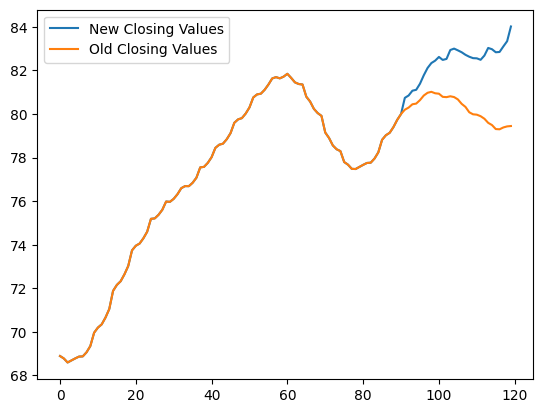

In [443]:
new_preds = pd.DataFrame(full_arr, columns = ["New Closing Values"])
old_preds = pd.DataFrame(original_values, columns = ["Old Closing Values"])
df_merged = pd.concat([new_preds, old_preds], axis=1)
df_merged
df_merged.plot()

In [444]:
start = dt.datetime(2020, 1, 1)
end = dt.datetime.now()
data = web.get_data_yahoo("GOOG", start, end)
data.to_csv("stock_data.csv")
data = pd.read_csv("stock_data.csv")
print(data)
data = data[["Date", "Close"]]
prophet = Prophet(daily_seasonality=True)
data.columns = ["ds", "y"]
prophet.fit(data[:-100])
future_dates = prophet.make_future_dataframe(periods=100)
predictions = prophet.predict(future_dates)
plot_plotly(prophet, predictions)
real = data["y"][-100:]
predict = predictions["yhat"][-100:]
if sum(real) > sum(predict):
  total = ((sum(real) - sum(predict)) / sum(real)) * 100
  #print(total)
else:
  total = ((sum(predict) - sum(real)) / sum(predict)) * 100
  #print(total)
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
print(smape(real, predict))

[*********************100%***********************]  1 of 1 completed

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy48ejy5t/u15zo35z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy48ejy5t/c6hr9pdt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97591', 'data', 'file=/tmp/tmpy48ejy5t/u15zo35z.json', 'init=/tmp/tmpy48ejy5t/c6hr9pdt.json', 'output', 'file=/tmp/tmpy48ejy5t/prophet_modelx36ufzwe/prophet_model-20230331162612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:26:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



           Date        Open        High         Low       Close   Adj Close  \
0    2020-01-02   67.077499   68.406998   67.077499   68.368500   68.368500   
1    2020-01-03   67.392998   68.625000   67.277199   68.032997   68.032997   
2    2020-01-06   67.500000   69.824997   67.500000   69.710503   69.710503   
3    2020-01-07   69.897003   70.149498   69.518997   69.667000   69.667000   
4    2020-01-08   69.603996   70.579002   69.542000   70.216003   70.216003   
..          ...         ...         ...         ...         ...         ...   
813  2023-03-27  105.320000  105.400002  102.629997  103.059998  103.059998   
814  2023-03-28  103.000000  103.000000  100.279999  101.360001  101.360001   
815  2023-03-29  102.720001  102.820000  101.029999  101.900002  101.900002   
816  2023-03-30  101.440002  101.610001  100.290001  101.320000  101.320000   
817  2023-03-31  101.709999  103.629997  101.440002  102.790001  102.790001   

       Volume  
0    28132000  
1    23728000  
2 

16:26:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


11.438423882061741
